In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e24/sample_submission.csv
/kaggle/input/playground-series-s3e24/train.csv
/kaggle/input/playground-series-s3e24/test.csv


In [2]:
%%time
import sys
!cp -f ../input/rapids/rapids.21.06 /opt/conda/envs/rapids.tar.gz
!cd -f /opt/conda/envs/ && tar -xzvf rapids.tar.gz
sys.path = ["/opt/conda/envs/rapids/lib"] + ["/opt/conda/envs/rapids/lib/python3.7"] + ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
!cp -f /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

cp: cannot stat '../input/rapids/rapids.21.06': No such file or directory
/bin/bash: line 1: cd: -f: invalid option
cd: usage: cd [-L|[-P [-e]] [-@]] [dir]
cp: cannot stat '/opt/conda/envs/rapids/lib/libxgboost.so': No such file or directory
CPU times: user 8.56 ms, sys: 15.3 ms, total: 23.9 ms
Wall time: 2.94 s


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
HTML(
"""
<style>
    h1{
        font-size:25px !important;
        font-family:Helvetica;
        
    }
    
    
</style>
"""
)

<h1>1 - IMPORTING TRAINING AND TESTING DATA</h1>

In [5]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e24/train.csv")
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


<h1>Some columns have names with spaces. This may cause some troubles later on. Let's remove them</h1>

In [6]:
df_train.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_train.columns ]

In [7]:
df_train.shape

(159256, 24)

In [8]:
target = 'smoking'

<h1>Let's check whether there is missing data in the dataset</h1>

In [9]:
df_train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [10]:
df_train.duplicated().sum()

0

In [11]:
df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'})

,n_unique
age,18
height(cm),14
weight(kg),28
waist(cm),531
eyesight(left),20
eyesight(right),17
hearing(left),2
hearing(right),2
systolic,112
relaxation,75


In [12]:
cat_features = df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'}).query("n_unique<=2").index.tolist()

In [13]:
num_features = list(set(df_train.drop(columns=['id',target]).columns) - set(cat_features))
num_features

['eyesight(left)',
 'systolic',
 'serum_creatinine',
 'height(cm)',
 'fasting_blood_sugar',
 'hemoglobin',
 'weight(kg)',
 'triglyceride',
 'Gtp',
 'eyesight(right)',
 'relaxation',
 'urine_protein',
 'age',
 'waist(cm)',
 'ALT',
 'AST',
 'HDL',
 'LDL',
 'Cholesterol']

In [14]:
features = num_features + cat_features

In [15]:
if len(num_features) + len(cat_features) + 2 != df_train.shape[1]:
    raise ValueError("dimensionverbose=ote match")

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, StandardScaler
X = df_train[features]
X = StandardScaler().fit_transform(X)
emb = TSNE(n_components=2,verbose=1,perplexity=20,early_exaggeration=25)
# X_emb = emb.fit_transform(X)

In [17]:
# df_tsne = pd.DataFrame(X_emb,columns=['c0','c1'])
# df_tsne[target] = df_train[target]

In [18]:
# plt.figure(figsize=(10,10))
# sns.scatterplot(data=df_tsne,x='c0',y='c1',hue=target)

In [19]:
df_test = pd.read_csv("/kaggle/input/playground-series-s3e24/test.csv")
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [20]:
df_test.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_test.columns ]

In [21]:
df_test.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental_caries          0
dtype: int64

In [22]:
def plot_train_test_distribution():
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_train_plot['label'] = 'TRAIN'
    
    df_test_plot = df_test[features].copy()
    df_test_plot['label'] = 'TEST'
    
    df_plot = pd.concat([df_train_plot,df_test_plot],axis=0)
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue='label',kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,x=f,orient='h',y='label')
            
            fig.show()
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue='label')

<Axes: xlabel='smoking', ylabel='count'>

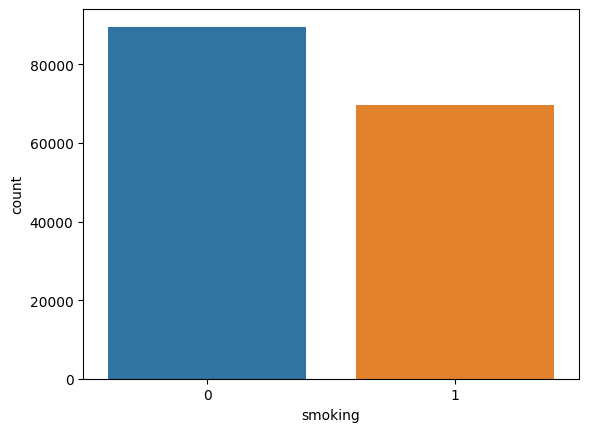

In [23]:
sns.countplot(data=df_train,x=target)

In [24]:
# plot_train_test_distribution()

In [25]:
def plot_target_variables_interaction():
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_plot = df_train
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue=target,kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,y=f,x=target)
            
            fig.show()
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue=target)

In [26]:
# plot_target_variables_interaction()

In [27]:
# sns.pairplot(data=df_train,hue=target)